# Clustering methods (work in progress)

This tutorial goes into detail about clustering methods and how to implement your own.

In [1]:
# Prerequisites
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

# Include this once we have a published release to fetch test data
# from toad.utils import download_test_data
# download_test_data()

In [2]:
from toad import TOAD, TOADPlotter

td = TOAD(xr.open_dataset("test_data/garbe_2020_antarctica.nc").coarsen(x=3, y=3, time=3, boundary='trim').mean())

In [3]:
# shifts have been precomputed
# td.compute_shifts('thk')

The `td.compute_clusters` function accepts clustering methods from the `sklearn.cluster` module.

In [4]:
from sklearn.cluster import HDBSCAN
from sklearn.cluster import DBSCAN

# HDBSCAN (default)
td.compute_clusters('thk', 
    method=HDBSCAN(
        min_cluster_size=25,
        min_samples=5, # optional, defaults to min_cluster_size
        cluster_selection_epsilon=0.1, # optional, defauls to 0
        metric='euclidean', # optional, defaults to 'euclidean'
    ),
    shifts_filter_func=lambda x: np.abs(x) > 0.8,
    overwrite=True,
)

# DBSCAN
td.compute_clusters('thk', 
    method=DBSCAN(
        eps=0.1,
        min_samples=5,
        metric='euclidean', # optional, defaults to 'euclidean'
    ),
    shifts_filter_func=lambda x: np.abs(x) > 0.8,
    overwrite=True,
)

## Defining your own clustering method
You can also define your own clustering method by extending the `sklearn.base.ClusterMixin` and `sklearn.base.BaseEstimator` classes: 

In [5]:
from sklearn.base import ClusterMixin, BaseEstimator

# Your custom clustering class must inherit from ClusterMixin and BaseEstimator
class MyClusterer(ClusterMixin, BaseEstimator):
    
    # Pass params to your method here
    def __init__(self, my_param):
        self.my_param = my_param

    # required method to perform clustering
    def fit_predict(self, coords: np.ndarray, weights=None, **kwargs):
        """
        Perform clustering on points with coords and weights and return cluster labels

        Args:
            coords (np.ndarray): A list of the coordinates to be clustered, e.g. (time, x, y)
            weights (np.ndarray): Importance weights for each data point. TODO is this just the var_dts ?? 

        Returns:
            tuple: A tuple containing:
                - np.ndarray: A 1D NumPy array of cluster labels for each data point, 
                  where -1 indicates unclustered points.
                - dict: A dictionary summarizing the HDBSCAN parameters used, suitable 
                  for storing as metadata or documentation.

        Notes: 
            While **kwargs can be used to pass parameters, using __init__ is preferred
            since those parameters will be automatically stored in the xarray attributes

        """       

        cluster_labels_array = ... # your clustering algorithm here

        return cluster_labels_array
    

# Then apply it with TOAD
# td.compute_clusters('thk', 
#     method=MyClusterer(
#         my_param=(1, 2.0, 2.0), # time, x, y thresholds
#     ),
#     shifts_filter_func=lambda x: np.abs(x) > 0.8,
#     overwrite=True,
# )

Real example of a custom clustering method: 

In [6]:
from sklearn.base import BaseEstimator, ClusterMixin

class MyClusterer(ClusterMixin, BaseEstimator):
    
    # required method
    def __init__(self, my_param=(0.5, 1.0, 1.0)):
        self.my_param = my_param


    # required method
    def fit_predict(self, coords: np.ndarray, weights=None, **kwargs):
        
        # Perform extremely crude clustering
        clusters = []
        cluster_labels_array = []
        for point in coords:
            for i, centroid in enumerate(clusters):
                if all(abs(point - centroid) <= self.my_param): break
            else: clusters.append(point); i = len(clusters) - 1
            cluster_labels_array.append(i)

        return cluster_labels_array
    

td = TOAD(xr.open_dataset("test_data/garbe_2020_antarctica.nc").coarsen(x=1, y=1, time=3, boundary='trim').mean())
td.compute_clusters('thk', 
    method=MyClusterer(
        my_param=(0.5, 2.0, 2.0), # time, x, y thresholds
    ),
    shifts_filter_func=lambda x: np.abs(x) > 0.8,
    overwrite=True,
)

{0: 17440, 1: 14619, 2: 13600, 3: 11953, 4: 11937, 5: 9872, 6: 7973, 7: 7858, 8: 6993, 9: 5147, 10: 5005, 11: 4746, 12: 4239, 13: 3354, 14: 3296, 15: 2400, 16: 2212, 17: 2020, 18: 2008, 19: 1762, 20: 1551, 21: 1450, 22: 1412, 23: 732, 24: 268, 25: 197, 26: 115, 27: 107, 28: 34, 29: 9}


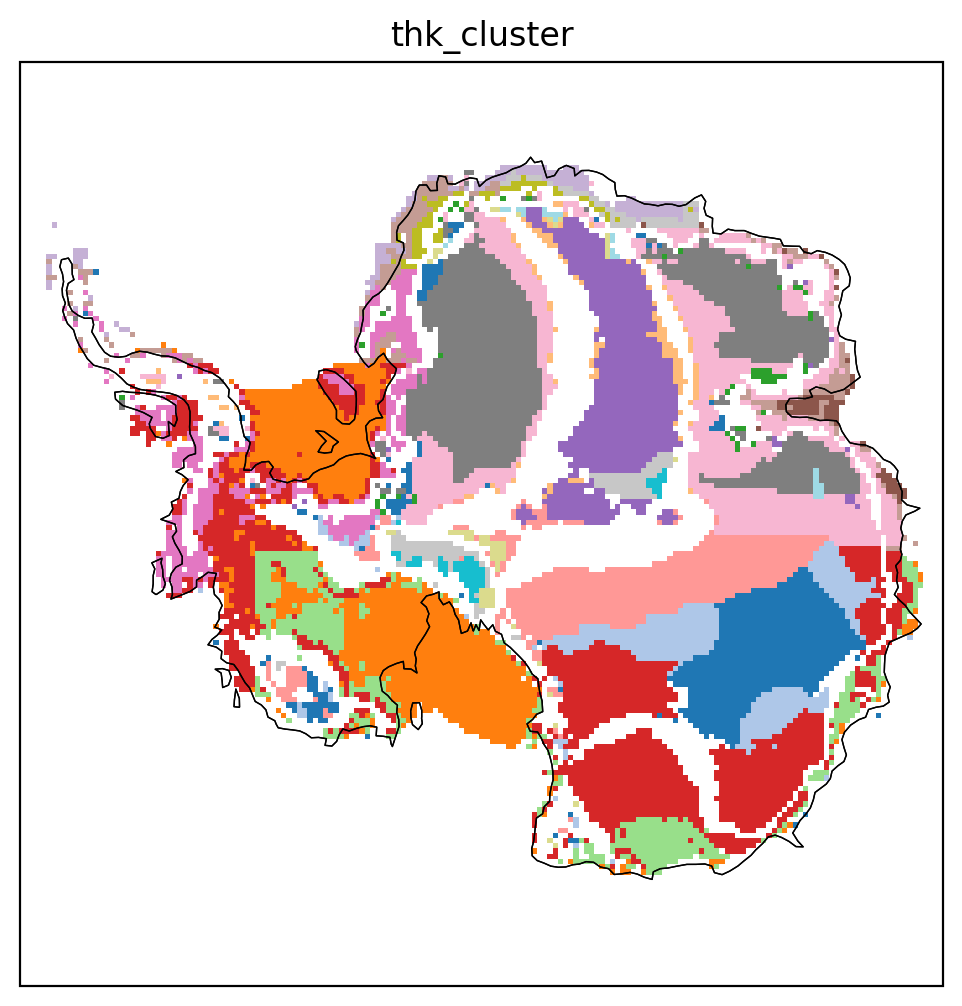

In [7]:
fig, ax = td.plotter().south_pole_plots(grid_labels=False)
td.plotter().plot_clusters_on_map('thk', ax=ax)
print(td.get_cluster_counts("thk"))

### Clustering score
**Cluster scoring:** Values range between 0 and 1. A score of 1 indicates a cluster with a perfect Heaviside function, while a score of 0 indicates a perfect linear function. Unclustered cells (id=-1) receiving a low score is a sign of good clustering, as it suggests that these cells largely evolve linearly. The scoring is simply the rescaled slope of a linear fit.

In [37]:
from sklearn.cluster import HDBSCAN

td = TOAD(xr.open_dataset("../testing-data/garbe_2020_antarctica.nc").coarsen(x=2, y=2, time=3, boundary='trim').mean())

td.compute_clusters(
    var='thk',
    method=HDBSCAN(min_cluster_size=25),
    shifts_filter_func=lambda x: np.abs(x) > 0.8,
)

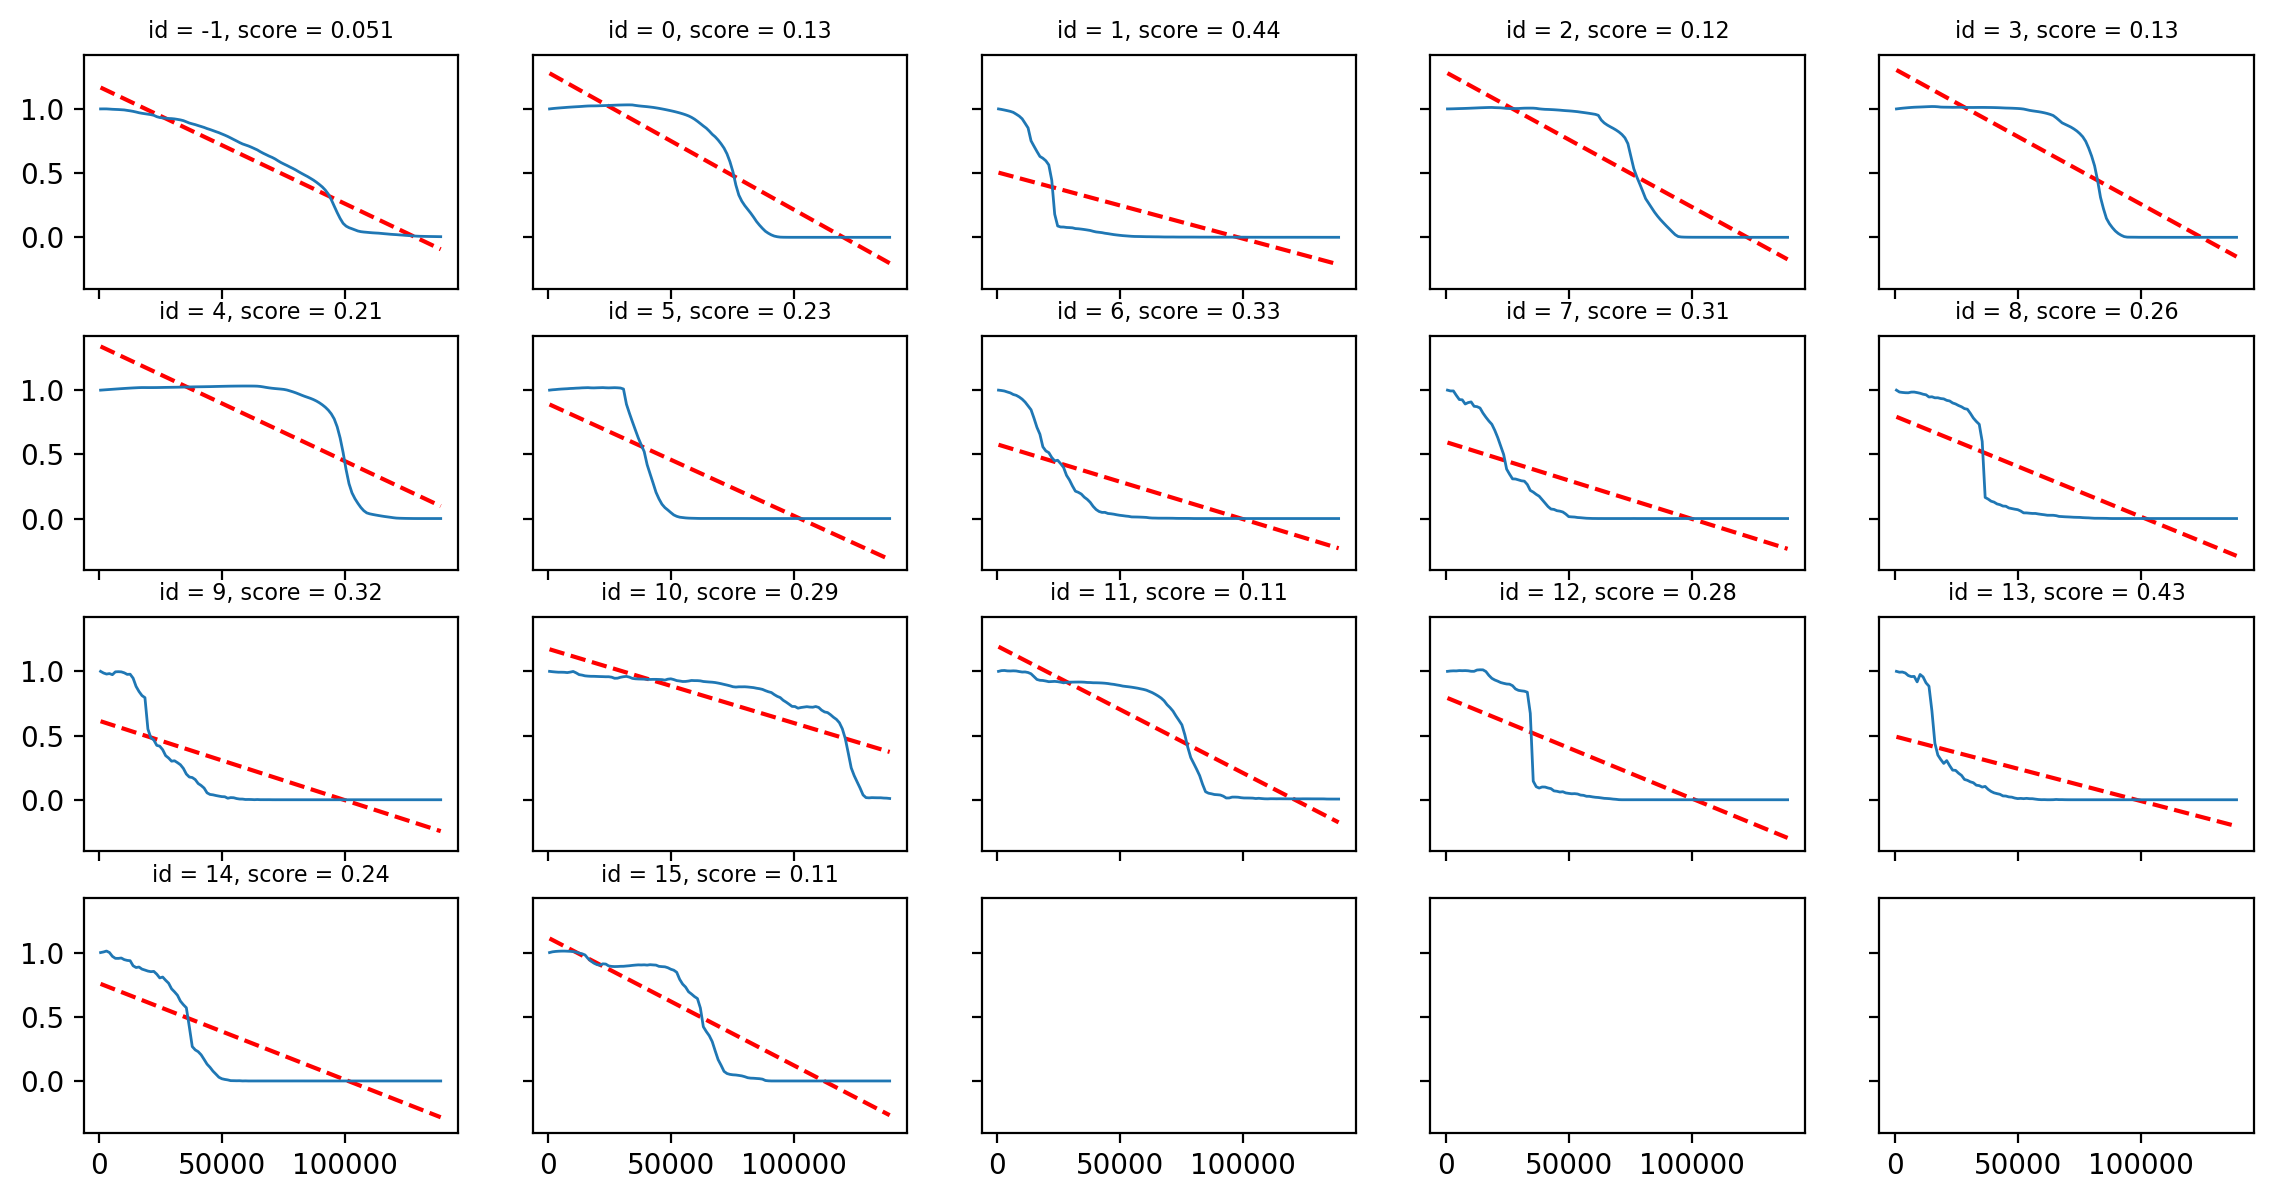

In [10]:
cluster_ids = td.get_cluster_ids('thk')[:20]
fig, axs = plt.subplots(np.ceil(len(cluster_ids)/5).astype(int), 5, figsize=(14,7), sharex=True, sharey=True)
for i, cluster_id in enumerate(cluster_ids):    
    ax = axs.flat[i]

    # comptue cluster score
    score, fit = td.cluster_stats('thk').general.compute_cluster_score(cluster_id, aggregation="mean", normalize="first", return_score_fit=True)
    
    # plot cluster score and cluster time series
    ax.plot(td.data.time, fit, "--r")
    td.get_cluster_timeseries("thk", cluster_id, aggregation="mean", normalize="first").plot(ax=ax, lw=1)
    ax.set_title(f"id = {cluster_id}, score = {score:.2}", fontsize=8)
    ax.set_xlabel("")
    ax.set_ylabel("")

# remove_ticks(axs.flat)